# Phd-teach-PhD: Approaching science with AI

**An introduction to scientific machine learning**

Guilherme Zagatti      
PhD candidate, NUS ISEP/IDS   
<gzagatti@u.nus.edu>   

# Outline

3. Motivation

4. Julia
    
5. ODEs with Julia

6. NeuralODE with Julia

7. UDEs: Universal differential equations

8. SINDy: Sparse identification of nonlinear dynamics
    
9. Behind the scenes

10. References

# Motivation

**Dynamical systems describe changes we observe**

## Intro

<div style="display: flex;">
<div style="margin-right: 10px;">
<p>I am a 2nd year PhD student at the <b>Institute of Data Science (IDS), NUS, Singapore</b>.</p>
<p>My work consist of investigating how the <b>structure of empirical temporal networks</b> could affect <b>diffusion processes in a population</b>.</p>
<p>My latest work involved the use of <b>Wi-Fi data for simulating the transmission of Covid-19</b> in our university campus.</p>
<p>Check my <a href="https://gzagatti.org">website</a> for more details.</p>
</div>
<div style="flex: 0 0 447px;">
<iframe width="447" height="252" src="https://www.youtube.com/embed/9NNPo_sdU6g?rel=0&modebranding=1" title="Covid-19 simulation" frameborder="0" allow="clipboard-write; encrypted-media; picture-in-picture" allowfullscreen></iframe>
</div>
</div>

## Workshop goal

At the end ot this workshop, you will:

* have a basic understanding of systems of ordinary differential equations (ODEs);

* be able to formulate a basic ODE problem, find its solution given a set of parameters, and estimate the parameters that best fit a dataset with Julia;

* learn the basics of Julia for scientific machine learning with particular attention to the following libraries:

In [243]:
using DifferentialEquations, DiffEqFlux, Flux, DataDrivenDiffEq, Plots

## “It is then by cause that we define time” (Poincaré 1903)

How do we learn about cause and effect if not by observing things changing in time? 

**Dynamical systems** are an evolution rule that defines a trajectory as a map (Meiss 2007):

<br/>

$$
    \text{time} ↦ \text{set of states}
$$

<br/>

As a mathematics discipline, the study of dynamical systems originates at the end of the 19th century spearheaded by [Henri Poincaré](https://plato.stanford.edu/entries/poincare/) who also developed an extensive theory of sciences.

## Physics: Harmonic oscillator

Describes the movement of an object with **mass $m$ attached to a spring under force $F$**.

The force follows **Hooke's law**, that is, it is proportional to the initial displacement.

<div style="display: flex;">
<div style="flex: 0 0 250px; margin-right: 10px;">
<img src="./assets/mass-spring.png" style="height: 250px;">
</div>
<div style="display: flex; align-items: center;">
$$
F = ma \Rightarrow
\frac{d^2 x}{dt^2} =-\frac{kx}{m} \Rightarrow
\begin{cases}
\frac{d x}{d t} = x^2 \\
\frac{d^2 x}{dt^2} =-\frac{kx}{m}
\end{cases}
$$
</div>
</div>

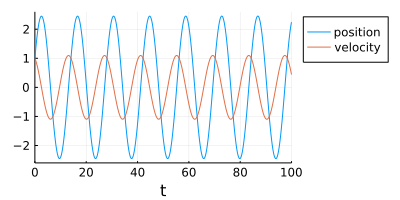

In [2]:
function ho!(du, u, p, t)
    m, k = p
    du[1] =  u[2]
    du[2] = -k*u[1]/m
end;
u0 = [1., 1.];
tspan = (0., 100.);
p = [1., 0.2];
prob = ODEProblem(ho!, u0, tspan, p);
sol = solve(prob);
plot(sol, label=["position" "velocity"], size=(400, 200), legend=:outertopright)

## Ecology: Lotka-Volterra

Describes the **dynamics of two-competing species**, the prey $x$ and predator $y$. Predator and prey come in contact to one another according to the proportion of each specie in the environment.

The prey is born with rate $\alpha$. The predator kills the prey with rate $\beta$. 

The predator needs to eat the prey to reproduce at rate $\delta$. The predator dies of natural cause at rate $\gamma$.

<div style="display: flex;">
<div style="flex: 0 0 250px; margin-right: 10px;">
<img src="./assets/fox-rabbit.png" style="height: 200px;">
</div>
<div style="display: flex; align-items: center;">
$$
\begin{cases}
\frac{dx}{dt} &= \alpha x - \beta xy \\
\frac{dy}{dt} & = \delta xy - \gamma y
\end{cases}
$$
</div>
</div>

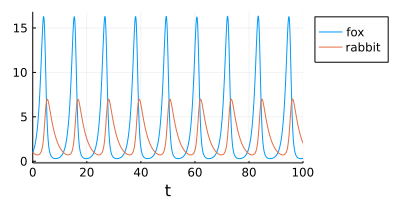

In [330]:
function lv!(du, u, p, t)
    α, β, δ, γ = p
    du[1] = α*u[1]      - β*u[1]*u[2]
    du[2] = δ*u[1]*u[2] - γ*u[2]
end;
u0 = [1., 1.];
tspan = (0., 100.);
p = [1.1, 0.4, 0.1, 0.4];
prob = ODEProblem(lv!, u0, tspan, p);
sol = solve(prob);
plot(sol, label=["fox" "rabbit"], size=(400, 200), legend=:outertopright)

## Epidemiology: SIR

Susceptible-infected-recovered: describes the **evolution of an infectious disease**. 

Susceptible and infected individuals come in contact to one another according to the proportion of each type in the population. The disease is then transmitted with rate $\beta$. An infected person recovers with rate $\gamma$.

<div style="display: flex;">
<div style="flex: 0 0 250px; margin-right: 10px;">
<img src="./assets/sneeze.png" style="width: 250px">
</div>
<div style="display: flex; align-items: center;">
$$
\begin{cases}
\frac{ds}{dt} &= - \beta si \\
\frac{di}{dt} & = \beta si - \gamma i \\
\frac{dr}{dt} &= \gamma i
\end{cases}
$$
</div>
</div>

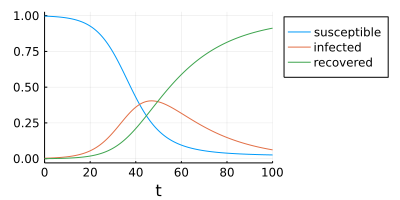

In [4]:
function sir!(du, u, p, t)
    β, γ = p
    du[1] = -β*u[1]*u[2]
    du[2] = β*u[1]*u[2] - γ*u[2]
    du[3] = γ*u[2]
end;
u0 = [0.997, .003, .0];
tspan = (0., 100.);
p = [0.2, 0.05];
prob = ODEProblem(sir!, u0, tspan, p);
sol = solve(prob);
plot(sol, label=["susceptible" "infected" "recovered"], size=(400, 200), legend=:outertopright)

## Economics: Solow growth model

The production function $f(\cdot)$ describes **economic growth as a function of effective units of capital $k$**. 

The **rate of effective capital growth** is dictated by the **savings rate** $s$ and **constrained by population growth, technology growth and capital depreciation rate**, $n$, $g$ and $\delta$ respectively. 

We usually assume that the **production function is of Cobb-Douglas** type: $f(k) = k^\alpha$. Economic assumptions imply that in a competitive market the share of income appropriate by capital $rk$ will eventually be equal to $\alpha$.

<div style="display: flex;">
<div style="flex: 0 0 250px; margin-right: 10px;">
<img src="./assets/growth.png" style="width: 200px;">
</div>
<div style="display: flex; align-items: center;">
$$
\frac{dk}{dt} = s f(k) - (n + g + \delta) k = s k^\alpha - (n + g + \delta) k
$$
</div>
</div>

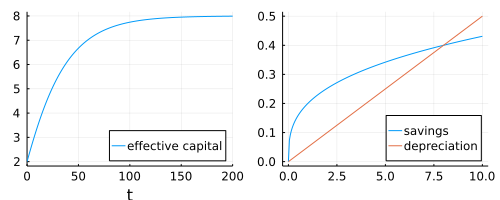

In [5]:
function solow!(du, u, p, t)
    s, α, n, g, δ = p
    du[1] = s*(u[1]^α) - (n + g + δ)*u[1]
end
u0 = [2.];
tspan = (0., 200.);
p = [0.2, 1/3, 0., 0., 0.05];
prob = ODEProblem(solow!, u0, tspan, p);
sol = solve(prob);
l = @layout [a b];
p1 = plot(sol, label="effective capital");
p2 = plot(k -> p[1]*(k^p[2]), 0:0.05:10, label="savings");
plot!(k -> (p[3] + p[4] + p[5])*k, 0:0.05:10, label="depreciation");
plot(p1, p2, layout=l, legend=:bottomright, size=(500, 200))

## A common thread

All of the presented models describe how the **variables of interest** change as a **function of time** given a set of parameters which are held fix.

Let our variables of interest be $ u = (u_1 \;  u_2 \;  \dots \;  u_M) \in \mathbb{R}^M$ and the law of motion $f: \mathbb{R}^M ↦ \mathbb{R}^M $.

We can express many **generic model** as a system of Ordinary Differential Equations (ODEs):

$$
\dot{u} = \frac{d u}{dt} = f(u)
$$

A key problem is whether any such models have a **unique solution,  $u(t)$,** that is:

> If we are given an initial set of parameters and an initial condition can we determine the state of the system at any point in the future?

## What is in the law of motion?

We placed **no restrictions on the law of motion $f(\cdot)$**. 

> In practical terms, if our system is in state $u \in U$ where will it be next?

If set $U$ is small we can simply list all possible laws (or functions) $K$:

$$
\vdots \\
f_k(u) = \begin{cases}
D \text{, if } u = D \\
C \text{, if } u \in \{A, C\}
\end{cases} \\
\vdots
$$

This approach might seem limited, but it is at the core of **stochastic Markov chains**. 

## Linear models

We can consider additional strategies. 

For instance, we can restrict ourselves only to **linear functions**. In this case variables change in proportion to the current state.

$$
\dot{u} = f(u) = A u = \begin{cases}
a_{11} u_1 + a_{12} u_2 + \dots + a_{1M} u_M \\
\vdots \\
a_{M1} u_1 + a_{M2} u_2 + \dots + a_{MM} u_M \\
\end{cases}
$$

where $\theta_k(u) = u_k$.

The **simple harmonic oscillator** presented in the beginning is a member of this class of functions.

In a sense **models are just composition of functions**.

## The universal approximator

This is where **neural networks (NN)** enter the picture --- arguments are borrowed from [Chris Rackauckas](https://mitmath.github.io/18337/lecture3/sciml.html):

1. the **Universal Approximation Theorem (UAT)** states that NN can approximate most well-behaved functions with any degree of precision which is controlled by the depth of the network (see Kratsios 2021);

2. **NN overcome the curse of dimensionality**, the approximation of a function of dimension $D$ only needs a polynomial number of parameters $D^C$ rather than $D^M$ where $C$ is a constant and $M$ the number of dimensions in the system (see Grohs 2019);

3. NN allows the **enforcement of many arbitrary constraints** via activation functions;

4. **NN are isotropic**, they are naturally non-aligned to a basis;

5. local optimization of NN are **more likely to reach global minimum** (see Lacotte 2020).




## Why don't we just approximate u(t) with NN?

NN are universal approximators so why don't we approximate as following:

$$
u = u(t; u_0) \approx NN(t; u_0)
$$

Most ODE problems do not have **analytical solution** and **are naturally expressed in terms of rates of change**.

We build from previous knowledge, NN are only used to describe the **unknown parts of our model**.

“<em>...the well-known adage ‘a picture is worth a thousand words’ might well be ‘a model is worth a thousand datasets’</em>”<br/>
Rackauckas 2020

## What about stochastic models?


<div style="display: flex; align-items: center;">
<div style="flex: 0 0 250px; align-items: center; margin-right: 10px; ">
<img src="./assets/coin-flip.png">
</div>
<div>
<p>Many scientific problems are expressed in terms of <b>random events</b>.
<p>The <a href="https://www.youtube.com/watch?v=AYnJv68T3MM">flip of a coin</a> can be modelled as a complex dynamical system or as a simple Bernouilli distribution.
<p>Although there are distinct basins of attraction, <b>sensitivity to and uncertainty about initial conditions</b> means that the motion can be described as a random process in practice (Diaconis 2007, Strzałko 2008).
<p>However, in <b>complex scenarios</b> the description of attractors and the distribution of initial states is not easy to observe.
<p>Tools to analyse <b>ODE systems</b> allow us to describe and characterize basins of attraction and the attractors themselves.
</div>
</div>

## Describing nature with models

<p>“<em>It is not sufficient for each elementary phenomenon to obey simple laws, all those to be combined must obey the same law as well.</em>”<br/>Poincaré 1902

A lot ingenuity and observation is required to develop models that are both **consistent with reality and existing theory**.

Scientific machine learning is a **set of tools for automated model discovery** to support the development of models from data.
    
<div style="display: flex;">
<div style="flex: 0 0 250px;">
<figure>
<img src="./assets/khun.png" style="height: 100px;">
<figcaption style="font-size: 8pt">source: <a href="https://commons.wikimedia.org/wiki/File:Epicycle_and_deferent.svg">Own work MLWatts, Public domain, via Wikimedia Commons</a></figcaption>
</figure>
</div>
<div style="display: flex; align-items: center;">
<p>According to Thomas Khun, science is a combination of <b>marginal revolutions and paradigm shifts</b>.
</div>
</div>

# Julia

**Into to the language and ecosystem**

## The <img src="./assets/julia-logo.svg" style="display: inline; vertical-align: text-top; width: 36pt; "></img> programming language

**Fast** designed for high-performance, just-in-time (JIT) compiled code.

**Reproducible environment** `Project.toml` and `Manifest.toml`, such as the ones in this course, contains all the instructions to reproduce the environment.

**General** from data-wrangling through data-analytics to data-reporting.

**Dynamic**, feels like Python.

**Composable**, not quite like Python. Multiple dispatch as a paradigm and meta-programming.

**Open source** MIT license and active developer community in the scientific machine learning field.

Visit [Julia's](https://julialang.org) website to get started. 

Check [Julia discourse](https://discourse.julialang.org/) to look for help, a lot of community interaction takes place in there.

## The quality of the language is reflected in the quality of packages

No other language can achieve the combination of **performance**, **mathematical notation** and **composition** that Julia provides:

* Differential Equations: [DifferentialEquations.jl](https://diffeq.sciml.ai/), [DiffEqFlux.jl](https://diffeqflux.sciml.ai/)

* Function approximation and manipulation: [JuMP.jl](https://jump.dev/), [ApproxFun.jl](https://juliaapproximation.github.io/ApproxFun.jl/), [DataDrivenDiffEq.jl](https://datadriven.sciml.ai/)

* Interval constraint programming and rigorous root finding: [IntervalRootFinding](https://juliaintervals.github.io/pages/packages/intervalrootfinding/)

* GPUs: [CUDA.jl](https://juliagpu.org/), [CuArrays.jl](https://juliagpu.org/cuda/)

* Linear algebra for large-systems:[BlockBandedMatrices.jl](https://juliamatrices.github.io/BlockBandedMatrices.jl/stable/), [InfiniteLinearAlgebra.jl](https://github.com/JuliaMatrices/InfiniteLinearAlgebra.jl)

* Automatic differentiation: [Zygote.jl](https://fluxml.ai/Zygote.jl/), [ForwardDiff.jl](https://juliadiff.org/ForwardDiff.jl/)

* Neural networks: [Flux.jl](https://github.com/FluxML/Flux.jl)

On top of that, **most of Julia is written in Julia**. No C, C++ or Fortran, just Julia.


## Installation

To follow the course, make sure to install the latest stable version of `Julia` from its [official page](https://julialang.org/downloads/). 

Then, clone this repository:

```
> git clone git@github.com:gzagatti/phdteachphd-sciml.git
```

After downloading the repository, activate its Julia environment and install its dependencies:

```
> cd phdteachphd-sciml/
> julia
               _
   _       _ _(_)_     |  Documentation: https://docs.julialang.org
  (_)     | (_) (_)    |
   _ _   _| |_  __ _   |  Type "?" for help, "]?" for Pkg help.
  | | | | | | |/ _` |  |
  | | |_| | | | (_| |  |  Version 1.6.1 (2021-04-23)
 _/ |\__'_|_|_|\__'_|  |  Official https://julialang.org/ release
|__/                   |

julia> ]
(@v1.6) pkg> activate .
  Activating environment at `./phdteachphd-sciml/Project.toml`
(@v1.6) pkg> instantiate
  Resolving package versions...
  ...
```


## Interacting with Julia

<div style="display: flex; align-items: center;">
<div style="display: flex; margin-right: 10px;">
<ol>
<li>as a scripting language <pre><code>> julia my-code.jl</code></pre></li>
<li>from the terminal using the built-in REPL <pre><code>julia> 1 + 1</code></pre></li>
<li>from a Jupyter notebook using <code>IJulia</code> <pre><code>julia> using IJulia; jupyterlab();</code></pre></li>
<li>from <a href="https://www.julia-vscode.org/">Julia for VSCode</a> a powerful IDE for interactive computing similar to Rstudio, check <a href="https://www.youtube.com/watch?v=IdhnP00Y1Ks">this presentation</a> for more details.</li>
</ol>
</div>
<div style="flex: 0 0 350px;">
<img src="./assets/vscode.png" style="width: 350px;">
</div>
</div>

## Paralellism

Ensure that Julia is started with **multi-thread support**.

To take advantage of this feature (although not required for this workshop), either:

* modify the environment `export JULIA_NUM_THREADS=4` before starting `julia` or `jupyter lab` --- in case you are using Jupyter notebook
* use the flag `-t` when starting Julia, `julia -t 4`

In [6]:
using Base.Threads
Threads.nthreads()

16

## Ecosystem

Julia comes with a built-in package manager, which means it is much easier to manage dependencies and avoid duplicating cached pre-compiled libraries.

Check for packages in [Julia Packages](https://juliapackages.com/) or in [JuliaHub](https://juliahub.com/ui/Packages). Learn more about the community behind Julia Packages by browsing [Julia GitHub Groups](https://julialang.org/community/organizations/).

All Julia configuration and installed packages are installed in `~/.julia`.

From the CLI, the package manager can be accessed by typing `]`

```
julia> ]
(@v1.6) pkg> activate MyPackage # activate the environment described in MyPackage
(@v1.6) pkg> add ExternalPackage # add external packages
(@v1.6) pkg> status # check the status of packages installed in the environment
```

Alternatively, use the `Package` module.

In [7]:
import Pkg
Pkg.DEFAULT_IO[] = stdout # only needed in Jupyter, before v1.6.2 comes out
Pkg.status()

      Status `~/phdteachphd-sciml/Project.toml`
  [6e4b80f9] BenchmarkTools v1.1.0
  [2445eb08] DataDrivenDiffEq v0.6.0
  [aae7a2af] DiffEqFlux v1.41.0
  [41bf760c] DiffEqSensitivity v6.54.0
  [0c46a032] DifferentialEquations v6.17.1
  [587475ba] Flux v0.12.4
  [f6369f11] ForwardDiff v0.10.18
  [7073ff75] IJulia v1.23.2
  [bdcacae8] LoopVectorization v0.12.48
  [961ee093] ModelingToolkit v5.20.0
  [1dea7af3] OrdinaryDiffEq v5.59.2
  [91a5bcdd] Plots v1.16.7
  [e88e6eb3] Zygote v0.6.14
  [37e2e46d] LinearAlgebra


## The anatomy of a package

Packages are usually organized as following.

```
MyFirstModule.jl
├── docs/
│   ├── src/
│   ├── Project.toml
│   └── make.jl
├── src/
│   ├── MyFirstModule.jl
│   └── ...
├── test/
│   ├── runtests.jl
│   └── ...
├── Project.toml
├── Manifest.toml
└── README.md
```

When looking at source code, a good idea is to start from `src/MyFirstModule.jl` to understand **what are the dependencies**, **which files are included** and **which names are exported**.

To learn more about packages, check [Chris Rackauckas video](https://www.youtube.com/watch?v=-lJK92bEKow).

## The anatomy of a module

Modules help to organize code into coherent units.

Although rarely done, we can also define the module in the current scope as done here for teaching purposes.

In [8]:
module MyFirstModule

# we can import functions defined elsewhere, they will be bound to the module's scope
using Statistics

# adds code from other files, this how you put everything together in your module
include("$(@__DIR__)/example.jl")

# we can also define functions and constants in the declaration file, but this is less common
const MyFirstConstant = 42

function random_average(n)
    mean(rand(n))
end

# functions and constants can be exported
export MyFirstConstant, hello, random_average

end;

## Using modules

There are two ways of adding modules to the local scope.

Either with `using`, in which case all names that are exported from the module are added to the local namespace.

In [9]:
using Statistics

mean(rand(10))

0.45694515398456675

Or with `import`, in which case only the module name is brought into scope. Users need to prepend the module name to access its definitions.

In [10]:
# we append `Main` as the module is defined in the current scope
import Main.MyFirstModule

println("""
$(MyFirstModule.hello("class"))
What's the meaning of life? $(MyFirstModule.MyFirstConstant). 
Tell me joke: $(MyFirstModule.random_average(10)).
""")

Hello, class!
What's the meaning of life? 42. 
Tell me joke: 0.4915088717976824.



## Looking for help

Julia is about multiple dispatching.

In [11]:
? MyFirstModule.hello

```
hello(world)
```

Prints a welcome message.


In [12]:
MyFirstModule.hello(2)

"Hello, don't be fooled 4!"

In [13]:
@which MyFirstModule.hello(2)

hello(n::Number) in Main.MyFirstModule at /home/guilherme/phdteachphd-sciml/docs/example.jl:8

In [14]:
methods(MyFirstModule.hello)

# 2 methods for generic function "hello":
[1] hello(n::Number) in Main.MyFirstModule at /home/guilherme/phdteachphd-sciml/docs/example.jl:8
[2] hello(world) in Main.MyFirstModule at /home/guilherme/phdteachphd-sciml/docs/example.jl:6

In [15]:
# will print the file where the called function is declared
# see @edit alternatively
@less MyFirstModule.hello("class")

"""
    hello(world)

Prints a welcome message.
"""
hello(world) = "Hello, $(world)!"

hello(n::Number) = "Hello, don't be fooled $(n*2)!"


## Arrays

In [16]:
b = [
    1
    2
    3
] # column vector

3-element Vector{Int64}:
 1
 2
 3

In [17]:
b = [1; 2; 3] # to avoid line breaks you can use `;`

3-element Vector{Int64}:
 1
 2
 3

In [18]:
b[1] # the index start at 1

1

In [19]:
b[0] # this will not work

LoadError: BoundsError: attempt to access 3-element Vector{Int64} at index [0]

In [20]:
b = Vector{Float64}(undef, 3) # initialize a vector with 3 elements
b[1] = b[2] = b[3] = 5
b

3-element Vector{Float64}:
 5.0
 5.0
 5.0

In [21]:
b = [1 2 3 4 5] # row vector, row vectors considered matrices

1×5 Matrix{Int64}:
 1  2  3  4  5

In [22]:
a = similar(b) # we can start a vector of the same type as b with undefined values

1×5 Matrix{Int64}:
 139924286665536  139924286341840  139924286665536  139924286665536  1

In [23]:
A = [
    1 1 1 1 1
    2 2 2 2 2
    3 3 3 3 3
    4 4 4 4 4
    5 5 5 5 5
] # define a matrix

5×5 Matrix{Int64}:
 1  1  1  1  1
 2  2  2  2  2
 3  3  3  3  3
 4  4  4  4  4
 5  5  5  5  5

In [24]:
A[2, 3] = 7 # change element of matrix

7

In [25]:
A[4, 5] = 7.2 # we cannot insert Floats to an integer matrix 

LoadError: InexactError: Int64(7.2)

In [26]:
A = Matrix{Float64}(undef, 5, 5) # another way to initialize a matrix

5×5 Matrix{Float64}:
 5.0e-324  9.4e-323   1.2e-322   1.8e-322   2.3e-322
 3.0e-323  1.0e-322   1.24e-322  1.83e-322  2.37e-322
 3.5e-323  1.04e-322  1.43e-322  2.03e-322  2.4e-322
 4.0e-323  1.1e-322   1.5e-322   2.2e-322   2.6e-322
 4.4e-323  1.14e-322  1.73e-322  2.27e-322  2.67e-322

In [27]:
A[:] = rand(5, 5)

5×5 Matrix{Float64}:
 0.0360904  0.792012  0.723822  0.324833  0.436957
 0.967736   0.724804  0.59657   0.451339  0.870701
 0.49809    0.756699  0.56469   0.469699  0.433321
 0.903382   0.10963   0.399455  0.466396  0.662436
 0.997866   0.237832  0.44626   0.450698  0.7808

In [28]:
a = @view A[4, :] # create a pointer to the 4th row

5-element view(::Matrix{Float64}, 4, :) with eltype Float64:
 0.9033815303411485
 0.10963022923048094
 0.3994549735909625
 0.46639624119121637
 0.6624356505506261

In [29]:
a[1:5] = repeat([1.], 5) # modifications to the pointer will modify the array
A

5×5 Matrix{Float64}:
 0.0360904  0.792012  0.723822  0.324833  0.436957
 0.967736   0.724804  0.59657   0.451339  0.870701
 0.49809    0.756699  0.56469   0.469699  0.433321
 1.0        1.0       1.0       1.0       1.0
 0.997866   0.237832  0.44626   0.450698  0.7808

In [30]:
v = Vector{Vector{Any}}(undef, 3) # we can also have array of arrays
v[1] = [4, 5]
v[2] = [5., 7., 9.]
v[3] = rand(1)
v

3-element Vector{Vector{Any}}:
 [4, 5]
 [5.0, 7.0, 9.0]
 [0.8080306939179902]

## Operations on arrays

In [31]:
map((x) -> x^2, b) # broadcast a function to all elements in b

1×5 Matrix{Int64}:
 1  4  9  16  25

In [32]:
broadcast(^, b, 2) # we can achieve the same result with the broadcast operator

1×5 Matrix{Int64}:
 1  4  9  16  25

In [33]:
b.^2 # the dot operator in front of many functions is a shorthand for the broadcast function

1×5 Matrix{Int64}:
 1  4  9  16  25

In [34]:
A*b' # matrix multiplication, notice the `'` operator which indicates the adjoint

5×1 Matrix{Float64}:
  7.275698398187961
 10.365911873059897
  7.750957158679079
 15.0
  8.519101346923199

In [35]:
A.*b # broadcast multiplication

5×5 Matrix{Float64}:
 0.0360904  1.58402   2.17147  1.29933  2.18479
 0.967736   1.44961   1.78971  1.80535  4.35351
 0.49809    1.5134    1.69407  1.8788   2.1666
 1.0        2.0       3.0      4.0      5.0
 0.997866   0.475664  1.33878  1.80279  3.904

In [36]:
b .= 2 # assignments can also be broadcast

1×5 Matrix{Int64}:
 2  2  2  2  2

In [37]:
b[:] = 2 # notice that this won't work

LoadError: ArgumentError: indexed assignment with a single value to many locations is not supported; perhaps use broadcasting `.=` instead?

In [38]:
b = 2; # and this simply allocates the integer 2 to variable b

## Control flow

This is very similar to other languages.

In [39]:
for i=1:2
    @show i
end

b = 10
while b >= 7
    println("this is b = $(b)")
    b -= 1
end

if b > 7
    print("Too high.")
else
    print("Too low.")
end

i = 1
i = 2
this is b = 10
this is b = 9
this is b = 8
this is b = 7
Too low.

Note that variables defined inside of loops and branches are not available in the calling scope.

In [334]:
for i = 1:1
    t = "t only exists inside of the loop."
    println(t)
end
println("exited from loop.")
@show t

t only exists inside of the loop.
exited from loop.


LoadError: UndefVarError: t not defined

This also aplies to the iterator.

In [41]:
@show i

LoadError: UndefVarError: i not defined

Nested loops are simple.

In [42]:
for i=1:2, j=2:3  print("(i, j) = ($(i), $(j))  ") end

(i, j) = (1, 2)  (i, j) = (1, 3)  (i, j) = (2, 2)  (i, j) = (2, 3)  

## Functions

You can define functions as:

In [43]:
f(x) = 2x^2 + 2x # notice that we don't need the * between 2 and x
f(2)

12

We can quickly take the derivative of our new functions.

In [44]:
using ForwardDiff # for automatic differentiation
ForwardDiff.derivative(f, 2.0)

10.0

There are alternative syntaxes for function definition. 

Let's define a function that computes the derivative of our function at any point $x$.

In [45]:
# notice that in Julia we can use unicode variables
# type \delta and press tab to get the character
function δf(x) 
    ForwardDiff.derivative(f, x)   
end
δf(2)

10

Notice that a convention in Julia is to add a bang `!` at the end of functions that modify its parameters. This is a community convention, it is not automatically enforced by the language in any way.

In [46]:
f!(x) = x[2] = 5

f! (generic function with 1 method)

In [47]:
b = [1 1 1 1]
f!(b)
b

1×4 Matrix{Int64}:
 1  5  1  1

## Multiple dispatch

Let's go back to `MyFirstModule.hello`. 

We could overload this function with a method that work slightly different for arrays.

In [48]:
MyFirstModule.hello(x::Array) = join([MyFirstModule.hello(i) for i in x], "\n")
println(MyFirstModule.hello(["Clara", 65, ["John", 10]]))

Hello, Clara!
Hello, don't be fooled 130!
Hello, John!
Hello, don't be fooled 20!


Notice how we were able to perform multiple dispatches even inside the function.

[If not abused](https://docs.julialang.org/en/v1/manual/performance-tips/#The-dangers-of-abusing-multiple-dispatch-(aka,-more-on-types-with-values-as-parameters), the **overhead incurred by multiple dispatch is minimal**, thus Julia is able to handle a large number of multiple types with a single function call.

Good use of multiple dispatch allows you to easily piggback not only on the APIs of [Base Julia](https://docs.julialang.org/en/v1/manual/interfaces/) but also on the large number of good quality packages.


## A note about “vectorization”

The **usual advice in Pythnon is to “vectorize” operations** as much as possible and avoid loops.

This is because vectorized operations call C programs which are optimized for the “vectorized” operation.

On the contrary, **in Julia “vectorization” does not necessarily improve performance**.

In [338]:
N = 1000
A = rand(N, N);
B = rand(N, N);

We will use one of the main benchamrking framework for Julia to compare the performance of snippets of code both in terms of **memory allocation** and **time**.

When in doubt, **this is a quick and effective way to locate bottlenecks** in your code.

In [339]:
using BenchmarkTools

<div style="display: flex; align-items: center;">
<div style="flex: 0 0 250px; margin-right: 10px; width: 250px;">
<figure>
<img src="./assets/array-order.png" style="width: 250px;">
<figcaption style="font-size: 8pt">source: <a href="https://commons.wikimedia.org/wiki/File:Row_and_column_major_order.svg">Cmglee, CC BY-SA 4.0, via Wikimedia Commons</a></figcaption>
</figure>
</div>
<div style="display=flex;">
<p>In Julia arrays are column-major.
<p>Which means that loops over columns are faster than over rows.
</div>
</div>

In [350]:
A[:]; # vectorize the matrix, this allow us to visualize the array-order

Row allocation will be slower than column allocation.

In [341]:
function modifyC0!(A, B, C, i)
    C[i, :] .= A[i, :] .* B[i, :]
end
@btime modifyC0!($A, $B, C, 2) setup=(C=Array{Float64}(undef, N, N));

  15.076 μs (2 allocations: 15.88 KiB)


In [346]:
function modifyC1!(A, B, C, i)   
    # the macro @. denotes that all operations in the line are broadcast
    @. C[:, i] = A[:, i] * B[:, i]
end                                   
@btime modifyC1!($A, $B, C, 2) setup=(C=Array{Float64}(undef, N, N));

  1.680 μs (2 allocations: 15.88 KiB)


In this case, the row-major loop was about 50 percent slower than the column major one.

We might think that our vectorized call to `.*` in `modifyC1!` is enough to ensure the code runs fast.

But in fact we are making unnecessary allocations. Using `@views` allow us to modify the array directly.

In [349]:
@views function modifyC2!(A, B, C, i)
    # the macro @. denotes that all operations in the line are broadcast
    @. C[i, :] = A[i, :] * B[i, :]
end
@btime modifyC2!($A, $B, C, 2) setup=(C=Array{Float64}(undef, N, N));

  16.557 μs (0 allocations: 0 bytes)


In [348]:
@views function modifyC3!(A, B, C, i)
    C[:, i] .= A[:, i] .* B[:, i]
end
@btime modifyC3!($A, $B, C, 2) setup=(C=Array{Float64}(undef, N, N));

  139.565 ns (0 allocations: 0 bytes)


One of the main advantages of Julia is just in-time compilation which means that the code is compiled just before execution.

We can actually print the intermediate representation of the LLVM compiled code:

In [56]:
@code_llvm 2 * 4

;  @ int.jl:88 within `*'
define i64 @"julia_*_13267"(i64 signext %0, i64 signext %1) {
top:
  %2 = mul i64 %1, %0
  ret i64 %2
}


The fact that Julia is a just-in time compiled means that it is able to achieve performance comparable to C.

For more information about JIT, check this [blog post by Carol Chen](https://carolchen.me/blog/technical/jits-intro/).

In fact, broadcasting is implemented with Julia as a loop which means that in many cases loops can perform better than the broadcast version.

Let's give it a try.

In [57]:
function modifyC4!(A, B, C, i)
    for j in 1:size(C)[1]
        C[j, i] = A[j, i] * B[j, i]
    end
end
@btime modifyC4!($A, $B, C, 2) setup=(C=Array{Float64}(undef, N, N));

  844.843 ns (0 allocations: 0 bytes)


It might be surprising to find that the function above did not perform as well as the broadcast version.

This is due to the fact that during the iteration Julia must check that the indices are within the bounds of the array.

If we promise the compiler that this is the case, we can surpass the performance of the broadcast implementation. 

We employ the `@inbounds` macro to tell the compiler that all indices are within the array bounds.

In [58]:
function modifyC5!(A, B, C, i)
    @inbounds for j in 1:size(C)[1]
        C[j, i] = A[j, i] * B[j, i]
    end
end
@btime modifyC5!($A, $B, C, 2) setup=(C=Array{Float64}(undef, N, N));

  117.452 ns (0 allocations: 0 bytes)


Alternatively, we could use the `@turbo` macro from the `LoopVectorization` package to achieve comparable performance with broadcast.

In [59]:
using LoopVectorization
@views function modifyC6!(A, B, C, i)
    @turbo C[:, i] .= A[:, i] .* B[:, i]
end
@btime modifyC6!($A, $B, C, 2) setup=(C=Array{Float64}(undef, N, N));

  120.224 ns (0 allocations: 0 bytes)


## Basic Types

Numbers come in different flavors in Julia.

In [60]:
typeof(1)

Int64

In [61]:
typeof(1.)

Float64

In [62]:
typeof(1 // 1)

Rational{Int64}

In [63]:
typeof(1f0)

Float32

More about numbers in the [documentation](https://docs.julialang.org/en/v1/manual/integers-and-floating-point-numbers/)

**Tuples**

In [64]:
b = (5, .2)

(5, 0.2)

As usual, tuples are not modifiable.

In [65]:
b[2] = 4

LoadError: MethodError: no method matching setindex!(::Tuple{Int64, Float64}, ::Int64, ::Int64)

**Dictionaries**

In [66]:
d = Dict(:d => "blue", 1 => "book", "ball" => 2)

Dict{Any, Any} with 3 entries:
  :d     => "blue"
  "ball" => 2
  1      => "book"

In [67]:
d[:d]

"blue"

In [68]:
d["ball"] = 45
d

Dict{Any, Any} with 3 entries:
  :d     => "blue"
  "ball" => 45
  1      => "book"

**Symbols**

Symbols are a way in which the language code can represent itself as a data structure. The evaluation of a symbol depends on the scope.

In [69]:
eval(:d) # remember that we defined d as a dictionary in the global scope

Dict{Any, Any} with 3 entries:
  :d     => "blue"
  "ball" => 45
  1      => "book"

In [70]:
d[:d] # within the dictionary d is a key

"blue"

Symbols are useful in metaprogramming, a feature which Julia shares with Lisp. This is an advanced feature briefly covered in the end of this section.

For more details check this [StackOverflow answer](https://stackoverflow.com/questions/23480722/what-is-a-symbol-in-julia).

**Iterators**

In [71]:
a = 1:2

1:2

In [72]:
typeof(a) # iterators are not arrays

UnitRange{Int64}

In [73]:
fieldnames(typeof(a)) # print the fields contained in a type

(:start, :stop)

In [74]:
collect(a) # convert range to vector

2-element Vector{Int64}:
 1
 2

## Types

They come in three flavors.

First, **immutable types**.

In [75]:
struct Point
    x::Float64
    y::Float64
end
a = Point(1., 0.)

Point(1.0, 0.0)

You cannot mutate immutable types.

In [76]:
a.x = 2 

LoadError: setfield! immutable struct of type Point cannot be changed

Second, **mutable types**.

In [77]:
mutable struct MutablePoint
    x::Float64
    y::Float64
end
b = MutablePoint(5., 3.)

MutablePoint(5.0, 3.0)

In [78]:
b.x = 2.
b

MutablePoint(2.0, 3.0)

It is not advisable to create mutable structures unless necessary.

In Julia immutable types are able to be stored closer to the CPU and have less cost of memory access --- they are stack allocated. On the other hand, mutable types are heap allocated.

Third, **abstract types** serve to define a hierarchy.

In [79]:
abstract type AbstractShape end 

In [80]:
struct Square <: AbstractShape
    x::Float64
    y::Float64
    length::Float64
end
Square(5., 5., 2.)

Square(5.0, 5.0, 2.0)

The type of elements inside of types can also be parametrized.

In [81]:
struct Rectangle{T<:Number} <: AbstractShape
    x::T
    y::T
    length::Float64
    height::Float64
end
Rectangle{Int64}(5., 5., 2., 3.)

Rectangle{Int64}(5, 5, 2.0, 3.0)

As always, we can oveload functions in Julia to extend the functionality of our types.

In [82]:
Base.:+(a::Point, b::Point) = Point(a.x + b.x, a.y + b.y)
Point(2., 3.) + Point(4., 5.)

Point(6.0, 8.0)

## Metaprogramming

Throughout this tutorial you might have seen many commands that start with `@`. These are called macros. 

Macro are functions on expressions. It allow us to dynamically write code. In Julia every statement is of type `Expression` so we can build code to build code.

An example is a fancy `@println`.

In [83]:
macro println(s) return :( println($s) ) end

@println (macro with 1 method)

In [84]:
@println "Hello, world!"

Hello, world!


The code takes an expression `s`, which is evaluated with `$s`. So, if `s` is a string like `"foo"`, it is evaluated to the string `"foo"` itself. 

The call to `println` is enclose in quotes --- `:( )` which is way to create expression objects.

Whenever the macro is called the expression is evaluated. Thus, if we pass `"foo"` it is like we typed in the console: `println("foo")`.

Check the [documentation on metaprogramming](https://docs.julialang.org/en/v1/manual/metaprogramming/) for more details.

## Additional tutorials

There are many additional materials on-line:

- [Julia documentation](https://docs.julialang.org/en/v1/): the official manual (including base libraries).
- [Get started with Julia](https://julialang.org/learning/): official recommendation of courses and books.
- [Learn Julia in Y minutes](https://learnxinyminutes.com/docs/julia/): a quick tutorial for experienced programmers.
- [Julia cheatshet](https://cheatsheets.quantecon.org/julia-cheatsheet.html): quick reference, mostly focused on numerical computation. 
- [Chris Rackauckas intro](https://www.youtube.com/watch?v=-lJK92bEKow): 30-minutes, quick video tutorial.
- [A deep introduction to julia for data science and scientific computing](http://ucidatascienceinitiative.github.io/IntroToJulia/): another Chris Rackauckas's intro with a lot of good insights into Julia for scientific machine learning.
- [Julia MIT](https://github.com/mitmath/julia-mit): simple tutorial on installing and using Julia targeted for MIT students.
- [MIT 18.337J/6.338J](https://github.com/mitmath/18337): full semester course of Julia for scientific machine learning.
- [QuantEcon](https://julia.quantecon.org/index_toc.html): in-depth introduction to quantitative economics with Julia.
- [ThinkJulia](https://benlauwens.github.io/ThinkJulia.jl/latest/book.html): in-depth introduction to Julia from a computer science perspectie

# ODEs with Julia

**Classical approaches for finding solutions and fitting data to ODEs**

## Section outline

We have already motivated the use of ODEs in scientific discovery.

We will now:

* formally introduce the initial value problem

* solve the initial value problem with Julia

* fit data to an ODE system using classical methods with Julia

## The initial value problem

Let our variables of interest be $ u = (u_1 \;  u_2 \;  \dots \;  u_M) \in \mathbb{R}^M$ and the law of motion $f: \mathbb{R}^M ↦ \mathbb{R}^M $. 

The initial value problem is to **find a solution $u(t; u_0)$** to the system of ODEs:

$$
\dot{u} = \frac{d u}{dt} = f(u)
$$

with initial condition, $(t_0, u_0)$.

The [Picard-Lindelöf theorem](https://en.wikipedia.org/wiki/Picard%E2%80%93Lindel%C3%B6f_theorem) shows that **the solution $u(t; u_0)$ is unique** under certain regularity conditions. 

We can develop an intuition as following. 

**Integrating the differential**, we obtain:

$$
\begin{aligned}
u(t) &= u(t_0) + \int_{t_0}^{t_T} f(u(t)) dt \\
&= u_0 + \int_{t_0}^{t_T} f(u(t)) dt \\
&\approx u_0 + \sum_{t = t_0}^{t_T} \Delta t f(u(t))
\end{aligned}
$$

This expression denotes the solution of the system as **the sum of the infinitesimal changes expressed by $f$** starting from $u_0$ to $t$.

However, this expression is a transcendental equation --- $u$ is expressed on both sides. Thus, it it does not constitute of a solution.

## Example: the solution to Lotka-Volterra

We will show how to compute the solution, $u(t; u_0)$, to the **Lotka-Volterra** problem with Julia step-by-step.

I would recommend that you adopt one the models presented in the introduction to follow along.

In [85]:
using DifferentialEquations # used for solving and analysing ODEs
using Plots # used for plotting

Check the documentation for [DifferentialEquations](https://diffeq.sciml.ai/) and [Plots](https://docs.juliaplots.org/) for additional tutorials and information.

To remind ourselves, the problem is defined as:

$$
\begin{cases}
\dot{u_1} = \alpha \, u_1 - \beta u_1 u_2 \\
\dot{u_2} =   \delta \, u_1 u_2 - \gamma \, u_2 \\
\end{cases}
$$

The first step is to define the function in Julia.

In [86]:
"""
    lv!(du, u, p, t)

Updates the diffential `du` at time `t` given state `u` and parameters `p`. 

This function produces side-effects by modifying `du`.
"""
function lv!(du, u, p, t)
    α, β, δ, γ = p
    du[1] = α*u[1] - β*u[1]*u[2]
    du[2] = δ*u[1]*u[2] - γ*u[2]
end;

We then define problem parameters such as the time interval we are interested and the model parameters.

In [87]:
# example and parameters from Wikipedia article
# https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations
u0 = [1.0f0, 1.0f0];
tspan = (0.0f0, 50.0f0);
lv_p = [1.1f0, 0.4f0, 0.1f0, 0.4f0];

The problem is initialized with `ODEProblem` and then solved with `solve`.

In [88]:
lv_prob = ODEProblem(lv!, u0, tspan, lv_p);
lv_sol = solve(lv_prob);

The algorithm that computes the solution for an ODE is called a **solver**.

Solvers take **different approaches to find a solution**. 

The **Euler method** is the canonical method of approximating the value of the function in the subsequent time period. It is derived as following

$$
\dot{u} = \frac{u_{t+ \Delta t} - u_t}{\Delta t} = f(u_t)
\Rightarrow u_{t+ \Delta t} = u_t + \Delta t f(u_t)
$$

We can compute our solution simply by **recursing** through this expression. 

However, this is **not computationally feasible**, because it requires a large number of iterations.

Some ODE problems are **stiff**. When our function presents fast dynamics in the short-range but smooth dynamics in the long-range, our solution could easily diverge. 

<figure>
<img src="./assets/stiff-ode.png" style="width: 300px; display: block; margin: 20px auto;">
<figcaption style="font-size: 8pt">source: <a href="https://mitmath.github.io/18337/lecture7/discretizing_odes.html">Rackauckas 2020, MIT 18.337J/6.388J Lecture 7</a></figcaption>
</figure>

The default solver is called `Tsit5`, short for Tsitouras 5/4 Runge-Kutta method. 

There are a **multitude of solvers** to select from, check a discussion about them in the [documentation](https://diffeq.sciml.ai/stable/solvers/ode_solve/).

The solution contains a lot of useful attributes: 

* the return code --- **check if the solver was successful**
* the interpolation method
* the time in which the solution was evaluted
* the state during these periods.

In [89]:
lv_sol = solve(lv_prob, Tsit5(), abstol=1e-8, reltol=1e-8)

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 573-element Vector{Float32}:
  0.0
  0.013000685
  0.023359306
  0.03632772
  0.05098274
  0.070223495
  0.09070352
  0.11328371
  0.13490745
  0.16270676
  0.1932758
  0.22225836
  0.256756
  ⋮
 49.44727
 49.50275
 49.555275
 49.617928
 49.679893
 49.737843
 49.791405
 49.849453
 49.896618
 49.943798
 49.990353
 50.0
u: 573-element Vector{Vector{Float32}}:
 [1.0, 1.0]
 [1.0091522, 0.9961133]
 [1.0165191, 0.9930358]
 [1.0258362, 0.989207]
 [1.0364926, 0.9849125]
 [1.0506917, 0.97932583]
 [1.0660692, 0.9734436]
 [1.0833448, 0.9670348]
 [1.1002103, 0.9609725]
 [1.1223646, 0.95328623]
 [1.1473538, 0.94497323]
 [1.1716686, 0.9372256]
 [1.2014223, 0.9281729]
 ⋮
 [16.210659, 3.0463386]
 [16.06685, 3.2586784]
 [15.861059, 3.4701228]
 [15.526332, 3.7340863]
 [15.101601, 4.0054584]
 [14.624382, 4.265869]
 [14.120178, 4.509681]
 [13.513265, 4.774262]
 [12.980757, 4.98716]
 [12.419495, 5.1961846]
 [11.844211, 5.3967013]

We can plot our solution which is is a function of time.

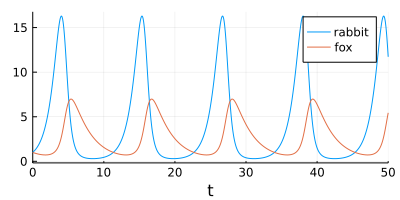

In [351]:
plot(lv_sol, label=["rabbit" "fox"], size=(400, 200))

As you can see our solution follows a cyclical pattern, an increase in the rabbit population is followed by an increase in the fox population which cause the rabbit population to decrease.

As the rabbit population decreases, so does the foxes. With less foxes, the rabbits increase again. So, the cycle goes on. 

We can also see our solution in the phase plane, with the `vars` argument. 

This corresponds to eliminating time from our system and looking at dynamics between $u_1$ and $u_2$ as described by the partial differential equation:

$$
\frac{\partial u_1}{\partial u_2} = - \frac{u_2}{u_1} \frac{\delta u_1 - \gamma}{\beta u_2 - \alpha}
$$


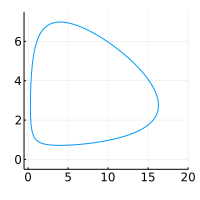

In [91]:
plot(lv_sol, vars=(1, 2), label=nothing)
plot!(xlims=(-.5, 20), ylims=(-.5, 7.5), size=(200, 200)) # adjust axis for better viz

We can derive many useful information from the solution object, `lv_sol`.

Get the size of the solution (number of interpolations).

In [92]:
size(lv_sol)

(2, 573)

The state at step 10.

In [93]:
lv_sol[10]

2-element Vector{Float32}:
 1.1223646
 0.95328623

The time at step 10.

In [94]:
lv_sol.t[10]

0.16270676f0

We can compute the solution for an arbitrary step inside our time span.

In [352]:
lv_sol(47.5)

2-element Vector{Float64}:
 5.429449585060256
 0.7339833576888409

It is very easy to change the problem and re-compute the solutions. 

Let's say we want to investigate the sensitivity of our solution to the initial conditions.

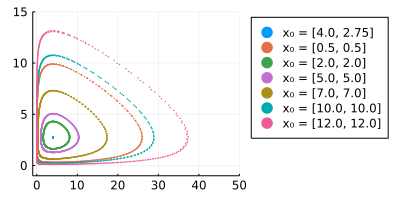

In [97]:
plot(size=(10, 10)) # initialize an empty plot
for u0 in [[lv_p[4]/lv_p[3], lv_p[1]/lv_p[2]], [.5, .5], [2., 2.], [5., 5.], [7., 7.], [10., 10.], [12., 12.]]
    new_prob = remake(lv_prob, u0=u0) # remake the problem, with new initial condition
    new_sol = solve(new_prob) # find new solution
    scatter!(new_sol, vars=(1, 2), label="x₀ = $(u0)", ms=1, msw=0) # plot the new solution
end
plot!(xlims=(-1, 50), ylims=(-1, 15), size=(400, 200), legend=:outertopright)

From visual inspection, we can see that the model has one stable solution at $(4.0, 2.75)$.

## Time-series data

Image that we obtain time-series data of the following form:

<table>
<thead>
<tr>
<th>t</th>
<th>rabbit</th>
<th>fox</th>
</tr>
</thead>
<tbody>
<tr>
<td>0.0</td>
<td>1.0</td>
<td>1.0</td>
</tr>
<tr>
<td>0.34</td>
<td>1.3</td>
<td>0.9</td>
</tr>
<tr>
<td>...</td>
<td>...</td>
<td>...</td>
</tr>
</tbody>
</table>

If we knew that in our ecological environment, the Lotka-Volterra is a good approximation of the food-chain.

How could we determine the parameters of the model from data?

## Finite differences

A simple approach would be to **compute the difference between time points**:

<table>
<thead>
<tr>
<th>t</th>
<th>Δt</th>
<th>rabbit</th>
<th>fox</th>
</tr>
</thead>
<tbody>
<tr>
<td>0.0</td>
<td>-</td>
<td>-</td>
<td>-</td>
</tr>
<tr>
<td>0.34</td>
<td>0.34</td>
<td>0.3</td>
<td>-0.1</td>
</tr>
<tr>
<td>...</td>
<td>...</td>
<td>...</td>
</tr>
</tbody>
</table>

We could then **fit our modified data to a linear regression** to determine our law of motion.

However **finite differences are not a good approximation of derivatives**, especially when data is sparse.

## Classical approaches

Instead of computing **finite differences**, we could take an inverse approach:

1. initialize a new model with **arbitrary parameters**. 
2. **find the solution** for the initial value problem given the proposed parameters.
3. **compute the cost**, that is, find the difference between our solution at the observed time-points and the data.
4. **modify the parameters of the model** in the direction that would cause the biggest reduction in cost.
5. return to step 2 and repeat **until convergence**.

## Fitting an ODE to Lotka-Volterra data

We will first **generate some data**, to simulate real-life data.

We could add some noise to our observations, but we will keep it simple and just **sample the solution at regular intervals**.

In [98]:
obs_span = (0.0f0, 10.0f0)
obs_steps = range(obs_span[1], obs_span[2], length=30);
obs = Array(lv_sol(obs_steps))

2×30 Matrix{Float32}:
 1.0  1.28157   1.66177   2.17475   2.86517   …  0.342995  0.386804  0.449648
 1.0  0.905891  0.829985  0.772154  0.733306     1.99902   1.76343   1.55845

There are **two Julia packages** that will help us with gradient descent in ODE solvers.

These tools allow us to perform a series of sensitivity analysis on ODE solutions.

In [99]:
using DiffEqSensitivity, DiffEqFlux

To estimate the parameters of the Lotka-Volterra equation we need to **define two functions**.

First, we need to tell Julia **how to predict the observations** given a set of parameters.

Second, we need to tell Julia **how to compute the loss**.

In [353]:
function predict(p)
    sensealg = ForwardDiffSensitivity()
    Array(solve(lv_prob, Tsit5(), u0=u0, p=p, saveat=obs_steps, 
        abstol=1e-4, reltol=1e-4, sensealg=sensealg))
end
loss(p) = sum(abs2, obs .- predict(p));

<br/>

While solvers define methods to find a solution to the initial value problem, **adjoints define methods to take the derivative of the solver with respect to the parameters in an efficient manner**.

In this context, adjoint and sensitivity algorithm are used interchangeably. We can pass to the `solve` function the **sensitivity algorithm** of our choice.

The [package documentation](https://diffeqflux.sciml.ai/dev/ControllingAdjoints/) has an extensive discussion of the different options.

We can now train our model to estimate the optimal parameters.

In [101]:
fitted_p = DiffEqFlux.sciml_train(loss, rand(4), maxiters=300)

u: 4-element Vector{Float64}:
 1.0999684015727262
 0.39997210642255077
 0.09999934754230555
 0.40000592284011005

As we can see the parameters are very close to the original ones.

In [102]:
lv_p

4-element Vector{Float32}:
 1.1
 0.4
 0.1
 0.4

Let's compute the solution using the fitted parameters and compare with the true solution. 

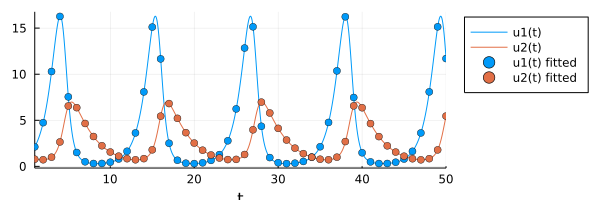

In [103]:
complete_sol = solve(lv_prob, p=fitted_p, tspan=tspan, saveat=1:50)
plot(lv_sol, size=[600, 200], legend=:outertopright)
scatter!(complete_sol, color=[1 2], label=["u1(t) fitted" "u2(t) fitted"])

# NeuralODE with Julia

**Fitting data to ODEs with NeuralODE**

## The initial value problem reviewed

We formulated the initial value problem in very general terms. The **law of motion** is:

$$
\dot{u} = \frac{d u}{dt} = f(u)
$$

If we knew nothing about the Lotka-Volterra model or if our data didn't fit this model, **how do we determine the law of motion from data?**

Loosely speaking, we know that **neural networks** can approximate any function. Thus, we could reformulate the law of motion while keeping the same generality as following:

$$
\dot{u} = NN(u)
$$

We know how to take **derivative of neural networks**, thus we can follow a very similar approach from the previous section.

## Fitting the NeuralODE: Lotka-Volterra reviewed

Let's remind ourselves of the true parameters of the model.

In [104]:
u0'

1×2 adjoint(::Vector{Float32}) with eltype Float32:
 1.0  1.0

In [105]:
lv_p'

1×4 adjoint(::Vector{Float32}) with eltype Float32:
 1.1  0.4  0.1  0.4

As well as our observations.

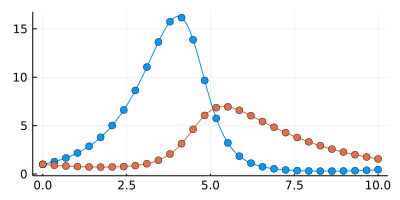

In [106]:
lv_short_sol = lv_sol(obs_span[1]:0.1:obs_span[2])
plot(lv_short_sol, color=[1 2], size=[400, 200])
scatter!(obs_steps, obs', color=[1 2], label=nothing)

One of the neural network packages in Julia is `Flux.jl`.

The `DiffEqFlux.jl` library provides support for scientific machine learning with lots of convenient functions for `Flux.jl`.

`FastChain` and `FastDense` are part of `DiffEqFlux.jl`. They are optimized for smaller neural networks with less overeheads and more efficient computation. 

They can replace `Chain` and `Dense` from `Flux.jl` in many scientific machine learning applications that only use small neural networks.

In [148]:
nn = FastChain(FastDense(2,50,tanh), FastDense(50,2))
nn_ode(u, p, t) = nn(u, p)
nn_prob = ODEProblem(nn_ode, u0, obs_span);

The `DiffEqFlux.sciml_train` routine allow us to pass a **callback**. 

This is a convenient way of logging training information and updating plots to track training progress.

We will use the callback to store the losses during training and to plot our results at the end.

In [150]:
function callback(true_sol, obs, prob, tsteps, losses, logevery=100)
    ct = 0
    return function (p, l=nothing; doplot=false) 
    if doplot
        plt = plot(true_sol, label=["u1(t)" "u2(t)"], color=[1 2], size=[600, 200], 
            legend=:outertopright)
        scatter!(plt, tsteps, obs', color=[1 2], label=nothing)
        fitted_sol = solve(prob, Tsit5(), u0=u0, p=p, saveat=tsteps)
        plot!(plt, fitted_sol(true_sol.t), label=["u1(t) fitted" "u2(t) fitted"], color=[3 4])
        scatter!(plt, tsteps, Array(fitted_sol)', label=nothing, color=[3 4])
        display(plt)
    else
        ct += 1
        push!(losses, l)
        if (ct % logevery == 0)
            @info "iter $(ct), loss $(losses[end])"
        end
    end
    return false
    end
end;

We initialize the parameters of the network and plot the resulting model before training.

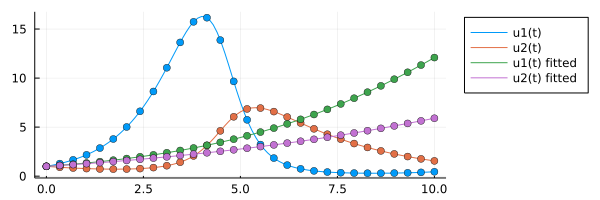

In [151]:
nn_losses = Vector{Float32}()
nn_cb = callback(lv_short_sol, obs, nn_prob, obs_steps, nn_losses, 100)
nn_init_p = initial_params(nn)
nn_cb(nn_init_p; doplot=true);

The definition of the prediction function and the loss are similar to the previous section.

But notice that we have selected a **different sensitivity algorithm** because we have substantially more parameters --- from 4 previously to 252 currently.

In [355]:
size(nn_init_p)

(252,)

In [149]:
function nn_predict(p)
    sensealg = InterpolatingAdjoint(autojacvec=ReverseDiffVJP(true))
    Array(solve(nn_prob, Tsit5(), u0=u0, p=p, saveat=obs_steps, 
        abstol=1e-6, reltol=1e-6, sensealg=sensealg))
end
nn_loss(p) = sum(abs2, obs .- nn_predict(p));

In this case, training the ODE requires only a few hundred iterations, but in other cases it can be very unstable as we will see in the next section.

**Do not worry about the warnings**: while training, the algorithm might guess parameters for which there is no unstable solution, the routine should then revert to a parameter set with a stable solution.

In [152]:
nn_fitted_p = DiffEqFlux.sciml_train(nn_loss, nn_init_p, cb=nn_cb, maxiters=300);

┌ Info: iter 100, loss 883.4224
└ @ Main In[150]:15
┌ Info: iter 200, loss 774.9384
└ @ Main In[150]:15
┌ Info: iter 300, loss 122.17381
└ @ Main In[150]:15
┌ Info: iter 400, loss 1.220829
└ @ Main In[150]:15
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /home/guilherme/.julia/packages/SciMLBase/kCcpg/src/integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /home/guilherme/.julia/packages/SciMLBase/kCcpg/src/integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /home/guilherme/.julia/packages/SciMLBase/kCcpg/src/integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /home/guilh

After training, we can plot the trajectory of losses.

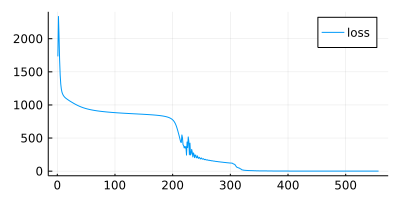

In [153]:
plot(nn_losses, size=[400, 200], label="loss")

As we can see our model was able to perfectly fit not only our observations but also our true model during the observed period.

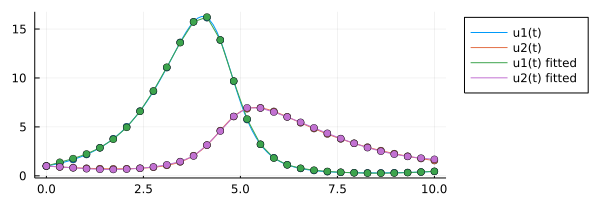

In [154]:
nn_cb(nn_fitted_p; doplot=true);

However if we extend the period of observation, we can see that our model clearly overfit the available observations.

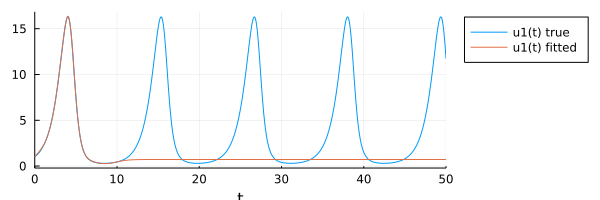

In [155]:
nn_complete_sol = solve(nn_prob, u0=u0, p=nn_fitted_p, tspan=tspan, saveat=lv_sol.t);
plot(lv_sol, vars=(0, 1), label="u1(t) true", size=[600, 200], legend=:outertopright)
plot!(nn_complete_sol, vars=(0, 1), label="u1(t) fitted")

# UDEs: Universal differential equations

**mixing neuralODEs with model assumptions**

## Incorporating knowledge into our system

In many circumstances we might have **some knowledge about the system**.

For instance, in the Lotka-Volterra model we might be able to observe the birth and death rate of preys and predators respectively.

It might be **only the nature of interaction between both species that is unclear from the data**.

Therefore, we could modify the law of motion from the previous section:

$$
\dot{u} = 
\begin{pmatrix} \alpha \\ -\delta \end{pmatrix} 
\begin{pmatrix} u_1 & u_2 \end{pmatrix}
+ NN(u)
$$

This approach, **denoted UDE**, was introduced in **Rackauckas et al. (2020)**.

## Fitting the UDE: Lotka-Volterra reviewed

Fitting an UDE is generally harder than fitting a neuralODE because of the constraints imposed by our assumptions. 

Thus, we will select a simpler network, that is deeper but with less parameters.

In [308]:
rbf(x) = exp.(-(x.^2))
ude_nn = FastChain(
    FastDense(2, 5, rbf), 
    FastDense(5, 5, rbf), 
    FastDense(5, 5, rbf), 
    FastDense(5, 2)
);

We incorporate our assumptions when defining the law of motion.

In [309]:
function ude!(du, u, p, t)
    out = ude_nn(u, p)
    du[1] = lv_p[1]*u[1] + out[1]
    du[2] = -lv_p[4]*u[2] + out[2]
end
ude_prob = ODEProblem(ude!, u0, obs_span);

We initialize the parameters of our network and plot the fitted results.

Notice that our assumptions and the initialized parameters, imply that in our initial solution the **rabbit population `u1(t)` explodes** by the end of the period. 

This will create a **lot of issues for training**.

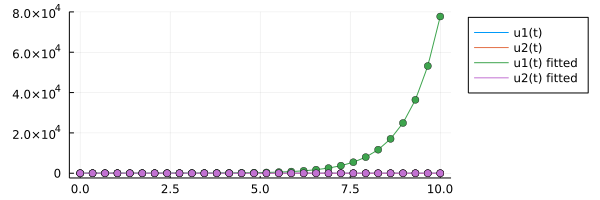

In [311]:
ude_losses = Vector{Float32}()
ude_cb = callback(lv_short_sol, obs, ude_prob, obs_steps, ude_losses, 100);
ude_init_p = initial_params(ude_nn)
ude_cb(ude_init_p; doplot=true);

**Training an UDE is no easy task.**

A good strategy to **avoid local minima** is to train on an **increasing amounts of observations**. Additional tips are available in the [documentation](https://diffeqflux.sciml.ai/dev/examples/local_minima/).

Second, we will use the `ForwardDiffSensitivity` algorithm for computing the Jacobian since we have a network with **less than 100 parameters** this will be more efficient.

Remember the discussion on adjoint methods in the [documentation](https://diffeqflux.sciml.ai/stable/ControllingAdjoints/).

In [310]:
function ude_predict(last)
    return function(p)
        sensealg = ForwardDiffSensitivity()
        Array(solve(ude_prob, Tsit5(), u0=u0, p=p, 
            tspan=(obs_steps[1], obs_steps[last]), saveat=obs_steps[1:last], 
            abstol=1e-6, reltol=1e-6, sensealg=sensealg))
    end
end
function ude_loss(last)
    pred = ude_predict(last)
    return function(p) 
        sum(abs2, obs[:, 1:last] .- pred(p))
    end
end;

In [312]:
@info "Training with first 10 observations."
ude_fitted_p = DiffEqFlux.sciml_train(ude_loss(10), ude_init_p, cb=ude_cb, maxiters=250)
@info "Training with first 20 observations."
ude_fitted_p = DiffEqFlux.sciml_train(ude_loss(20), Array(ude_fitted_p), cb=ude_cb, maxiters=250)
@info "Training with all observations"
ude_fitted_p = DiffEqFlux.sciml_train(ude_loss(30), Array(ude_fitted_p), cb=ude_cb, maxiters=500);

┌ Info: Training with first 10 observations.
└ @ Main In[312]:1
┌ Info: iter 100, loss 1.1445273
└ @ Main In[150]:15
┌ Info: iter 200, loss 0.9736066
└ @ Main In[150]:15
┌ Info: iter 300, loss 0.0015273148
└ @ Main In[150]:15
┌ Info: iter 400, loss 3.3914963e-5
└ @ Main In[150]:15
┌ Info: Training with first 20 observations.
└ @ Main In[312]:3
┌ Info: iter 500, loss 25935.883
└ @ Main In[150]:15
┌ Info: iter 600, loss 1108.2737
└ @ Main In[150]:15
┌ Info: iter 700, loss 941.45056
└ @ Main In[150]:15
┌ Info: iter 800, loss 328.7363
└ @ Main In[150]:15
┌ Info: iter 900, loss 112.77839
└ @ Main In[150]:15
┌ Info: Training with all observations
└ @ Main In[312]:5
┌ Info: iter 1000, loss 6.801305e6
└ @ Main In[150]:15
┌ Info: iter 1100, loss 783.01
└ @ Main In[150]:15
┌ Info: iter 1200, loss 782.2307
└ @ Main In[150]:15
┌ Info: iter 1300, loss 781.1583
└ @ Main In[150]:15
┌ Info: iter 1400, loss 779.88947
└ @ Main In[150]:15
┌ Info: iter 1500, loss 70.98013
└ @ Main In[150]:15
┌ Info: iter 

Despite the difficulty in training the UDE we succeed in obtaining a **good approximation** to our observations.

The **fit is not as tight** as with a pure neuralODE approach, which might be indicative of less overfitting.

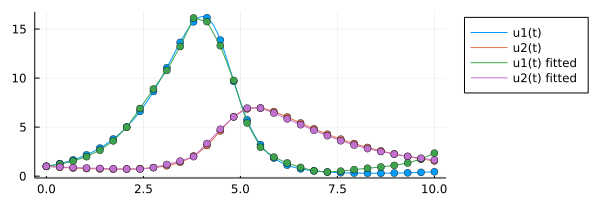

In [313]:
ude_cb(ude_fitted_p; doplot=true);

However, despite incorporating new assumptions the UDE also miserably failed to extrapolate to the true model.

If anything, it at least predicted another cycle.

**So, what did we gain?**

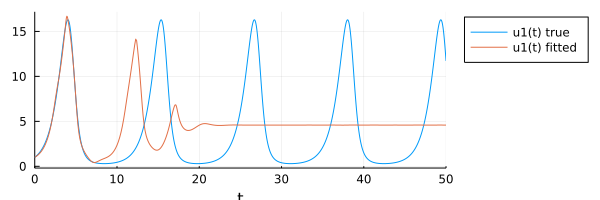

In [314]:
ude_complete_sol = solve(ude_prob, u0=u0, p=ude_fitted_p, tspan=tspan, saveat=lv_sol.t);
plot(lv_sol, vars=(0, 1), label="u1(t) true", size=[600, 200], legend=:outertopright)
plot!(ude_complete_sol, vars=(0, 1), label="u1(t) fitted")

# SINDy: Sparse identification of non-linear dynamical systems

**Simplifying the UDE, when less is more**

## UDE meets SINDy

In the previous section we described a method for **mixing neural networks with classical model description**.

As we have shown, **the network tends to overfit the data** and does not extrapolate well beyond the observation window.

When describing the law of motion we proposed a general form in terms of a neural network: $\dot{u} = f(u) = NN(u)$.

To improve generalizability and explainability, we could **project the output of our fitted neural network in a set of basis functions** of interest which would allow us to explain the unknown parts of our model in sparse terms.

**There are alternatives.**

## Taylor series

We could have the class of **polynomial functions**. 

We know from [Taylor's theorem](https://en.wikipedia.org/wiki/Taylor%27s_theorem#Generalizations_of_Taylor's_theorem) that a $k$-times differentiable function $f$ can be approximated with a Polynomial of $k$ degrees. In one dimension, we have:

$$
\dot{u} = f(u_0) + \sum_{k \in \mathbb{N}_+} \frac{d^k f}{du^k}(u_0) \frac{(u - u_0)^k}{k!} = \sum_{k \in \mathbb{N}} \xi_k \theta_k(u)
$$

where $\theta_k(u) = u^k$.

The advantage of Taylor series is that we can **describe $f(\cdot)$ according to the rate of change around a small neighborhood of our initial condition**.

When $k = 1$, we can approximate the function as a linear function.


## Cyclical decompositions

Alternatively, we can generate any [square-integrable functions](https://en.wikipedia.org/wiki/Square-integrable_function) --- that is, functions with a finite norm --- using the [Fourier series](https://en.wikipedia.org/wiki/Fourier_series).

Let $\cos_k(t) = \cos \left({\tfrac{2k \pi}{L}}t \right)$ and $\sin_k(t) = \sin \left({\tfrac{2k \pi}{L}}t \right)$

$$
\dot{u} = \sum_{k \in \mathbb{N}^+} \langle f, \cos_k \rangle \cos_k(t) +  \langle f, sin_k \rangle sin_k(t)
$$

where $\langle f \, , \, g \rangle = \int f(x) g(x) \, dx$ is the inner product of two functions.

The Fourier series allow us to describe **changes in terms of cycles**.

The lower the $k$, the lower the frequency of the cycle.

## Basis functions

We have a few general methods of generating arbitrary functions that respect general assumptions about the law of motion.

Let the **observations** $X$, the dictionary of **basis functions** $\Theta(\cdot)$ and the **coefficient matrix** $\Xi$: 

$$
X = \begin{pmatrix}
& \dots &  \\ 
& x_n^\top & \\
& \dots &
\end{pmatrix}
\,\text{,}\quad
\Theta (\cdot) = \begin{pmatrix}
\vdots & \vdots & \vdots \\ 
\theta_0(\cdot) & \dots & \theta_K(\cdot) \\
\vdots & \vdots & \vdots
\end{pmatrix}
\,\text{,}\quad
\Xi (\cdot) = \begin{pmatrix}
\vdots & \vdots & \vdots \\ 
\xi_0 & \dots & \xi_M \\
\vdots & \vdots & \vdots
\end{pmatrix}
$$

Often, the number of basis function $K$ is proportional to the maximum dimension $D$ of the basis functions, such that $K \propto D^N$.

The dynamical problem can thus be **reformulated** as
$
\underbrace{\dot{X}}_{\scriptscriptstyle{N \times M}} = \underbrace{\Theta(X)}_{\scriptscriptstyle{N \times K}} \, \underbrace{\Xi}_{\scriptscriptstyle{K \times M}}
$

## Sparse Identification of Nonlinear Dynamics (SINDy)

A linear regression can help us to find the parameters that best fit the data. Add some regularization parameters to optimize sparsity:

$$
\hat{\Xi} = \underset{\mathrm{\Xi}}{argmin} \, || \dot{X} - \Theta(X) \, \Xi ||_2 + \lambda || \Xi ||_1
$$

In **theory**, if the number of observations is much larger than that of parameters $N >> K M$, our system is identifiable.

In **practice**, there are number of problems:

1. Numerical errors in the computation of $\dot{X}$

2. The number of states $N$ might be prohibitively large

3. Curse of dimensionality: number of basis functions grows arbitrarily large as $D^M$

See **Brunton (2016)** for more details.

## Finding the true model with SINDy

Assume we know very little about our model. We assume that the law of motion might be **proportional to the current population** and might be **cyclical**. 

In [357]:
using LinearAlgebra, ModelingToolkit, DataDrivenDiffEq
@variables x[1:2]
b = [polynomial_basis(x, 5); sin.(x)]
basis = Basis(b, x)
println(basis)

Model ##Basis#20415 with 23 equations
States : x₁ x₂
Independent variable: t
Equations
φ₁ = 1
φ₂ = x₁
φ₃ = x₁^2
φ₄ = x₁^3
...
φ₂₃ = sin(x₂)


First, will compute our predictions for the observed points.

In [358]:
obs_pred = Array(solve(ude_prob, p=ude_fitted_p, saveat=obs_steps))

2×30 Matrix{Float32}:
 1.0  1.22226   1.53712   1.98926   …  1.09662  1.34475  1.73794  2.34957
 1.0  0.935469  0.879889  0.832012     2.2494   2.02501  1.82729  1.65241

The part that we are unsure refers to the interaction between species. 

Thus, we will compute both:

* the **true interactions** from our predictions which is unknown in a real experimental setting 

* our **predicted interactions** which is computed from the neural network 

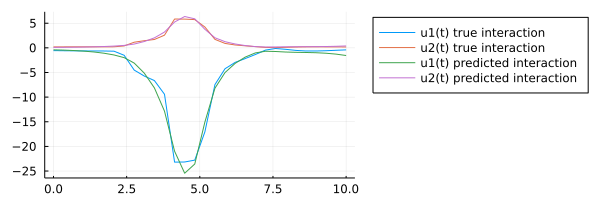

In [317]:
interaction_true = [-lv_p[2]*(obs_pred[1, :].*obs_pred[2, :])'; lv_p[3]*(obs_pred[1, :].*obs_pred[2, :])']
interaction_pred = ude_nn(obs_pred, ude_fitted_p)
plot(obs_steps, interaction_pred', label=["u1(t) true interaction" "u2(t) true interaction"])
plot!(obs_steps, interaction_true', label=["u1(t) predicted interaction" "u2(t) predicted interaction"])
plot!(size=(600, 200), legend=:outertopright)

Let's compute the error between the true interaction and our prediction.

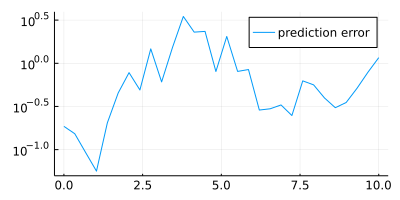

In [360]:
plot(obs_steps, norm.(eachcol(interaction_pred-interaction_true)), yaxis=:log, 
    label="prediction error", size=(400, 200))

In Julia, the SINDy optimizer is implemented as the **sequentially thresholded least squares (STLSQ) algorithm**.

We need to determine the sequence of penalty terms along the optimization. 

In [319]:
λs = Float32.(exp10.(-7:0.1:5))
sindy_opt = STLSQ(λs);

We then estimate the coefficients for the true interaction.

If our model is correctly specified we should be able to find the true model.

In [320]:
true_sindy_problem = ContinuousDataDrivenProblem(obs_pred, obs_steps, DX=interaction_true);
true_sindy_sol = solve(true_sindy_problem, basis, sindy_opt)
print(true_sindy_sol, Val{true})

Explicit Result
Solution with 2 equations and 2 parameters.
Returncode: sucess
Sparsity: 2.0
L2 Norm Error: 1.1215784e-6
AICC: 59.72616987961989

Model ##Basis#20041 with 2 equations
States : x₁ x₂
Parameters : p₁ p₂
Independent variable: t
Equations
Differential(t)(x₁) = p₁*x₁*x₂
Differential(t)(x₂) = p₂*x₁*x₂

Parameters:
   p₁ : -0.4
   p₂ : 0.1


Now that we are convinced that SINDy can identify the nature of the true interaction, we can estimate the coefficients of our predicted interaction.

In [323]:
pred_sindy_problem = ContinuousDataDrivenProblem(obs_pred, obs_steps, DX=interaction_pred);
pred_sindy_sol = solve(pred_sindy_problem, basis, sindy_opt);
print(pred_sindy_sol, Val{true})

Explicit Result
Solution with 2 equations and 2 parameters.
Returncode: sucess
Sparsity: 2.0
L2 Norm Error: 6.0648937
AICC: -2.2869913027836724

Model ##Basis#20086 with 2 equations
States : x₁ x₂
Parameters : p₁ p₂
Independent variable: t
Equations
Differential(t)(x₁) = p₁*x₁*x₂
Differential(t)(x₂) = p₂*x₁*x₂

Parameters:
   p₁ : -0.39
   p₂ : 0.098


As we can see from above SINDy identifies the correct model.

Let's compute its solution.

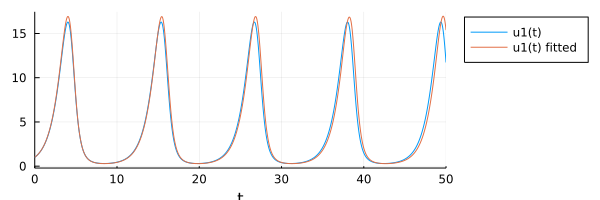

In [324]:
function sparse_ude!(du, u, p, t)
    out = pred_sindy_sol(u, p)
    du[1] = lv_p[1]*u[1] + out[1]
    du[2] = -lv_p[4]*u[2] + out[2]
end
sparse_ude_prob = ODEProblem(sparse_ude!, u0, tspan)
sparse_ude_sol = solve(sparse_ude_prob, Tsit5(), p=parameters(pred_sindy_sol), saveat=lv_sol.t)
plot(lv_sol, vars=(0, 1))
plot!(sparse_ude_sol, vars=(0, 1), label="u1(t) fitted", size=(600, 200), legend=:outertopright)

## When we don't know anything

We might be tempted to follow the same procedure with the NeuralODE model in which $\dot{u} = NN(u)$.

As we will show, SINDy fails to find te correct solution for this model.

First we will compute the true derivatives.

In [361]:
dlv = Matrix{Float32}(undef, 2, size(obs)[2])
for (i, du) in enumerate(eachcol(dlv)) lv!(du, obs[:, i], lv_p, nothing) end

With the true derivatives, we can convince ourselves that SINDy can find the true model.

In [362]:
true_sindy_problem = ContinuousDataDrivenProblem(obs, obs_steps, DX=dlv);
true_sindy_sol = solve(true_sindy_problem, basis, sindy_opt)
print(true_sindy_sol, Val{true})

Explicit Result
Solution with 2 equations and 4 parameters.
Returncode: sucess
Sparsity: 4.0
L2 Norm Error: 0.0
AICC: Inf

Model ##Basis#20424 with 2 equations
States : x₁ x₂
Parameters : p₁ p₂ p₃ p₄
Independent variable: t
Equations
Differential(t)(x₁) = p₁*x₁ + p₂*x₁*x₂
Differential(t)(x₂) = p₃*x₂ + p₄*x₁*x₂

Parameters:
   p₁ : 1.1
   p₂ : -0.4
   p₃ : -0.4
   p₄ : 0.1


The error between the true derivative and our estimated derivative tends to be even smaller than in the UDE case which another side of overfitting.

Perhaps, SINDy will help us with that.

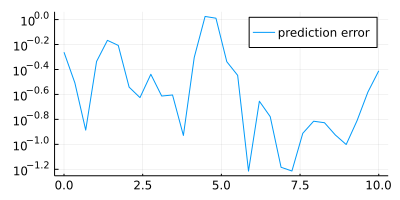

In [363]:
nn_pred = nn(obs, nn_fitted_p)
plot(obs_steps, norm.(eachcol(nn_pred-dlv)), yaxis=:log, 
    label="prediction error", size=(400, 200))

Now let's check what SINDy will find using the estimated NeuralODE model.

In [328]:
nn_sindy_problem = ContinuousDataDrivenProblem(obs, obs_steps, DX=nn_pred);
nn_sindy_sol = solve(nn_sindy_problem, basis, sindy_opt)
print(nn_sindy_sol, Val{true});

Explicit Result
Solution with 2 equations and 5 parameters.
Returncode: sucess
Sparsity: 5.0
L2 Norm Error: 3.4951644
AICC: 8.646652138751486

Model ##Basis#20132 with 2 equations
States : x₁ x₂
Parameters : 5
Independent variable: t
Equations
Differential(t)(x₁) = p₁*x₁ + p₂*x₁*x₂
Differential(t)(x₂) = p₃*x₂ + p₄*(x₂^2) + p₅*x₁*(x₂^2)

Parameters:
   p₁ : 1.1
   p₂ : -0.4
   p₃ : 0.03
   p₄ : -0.09
   p₅ : 0.02


SINDy was unable to find the correct model and extrapolation fails.

As we can see there's [no free lunch after all](https://en.wikipedia.org/wiki/No_free_lunch_theorem).

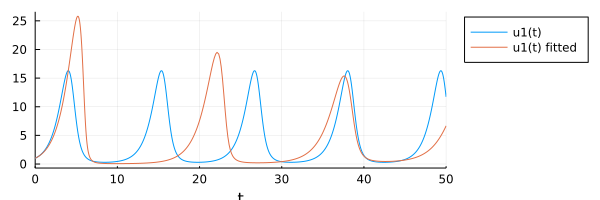

In [329]:
sparse_nn!(u, p, t) = nn_sindy_sol(u, p)
sparse_nn_prob = ODEProblem(sparse_nn!, u0, tspan)
sparse_nn_sol = solve(sparse_nn_prob, Tsit5(), p=parameters(nn_sindy_sol), saveat=lv_sol.t)
plot(lv_sol, vars=(0, 1))
plot!(sparse_nn_sol, vars=(0, 1), label="u1(t) fitted", size=(600, 200), legend=:outertopright)

# Behind the scenes 

**The maths neuralODEs**

## A unique solution

The solution to initial value problem problem **$u(t; u_0)$** is a function that indicates **the state of the system at every point in time given the initial conditions**.

Given the constraints of the problem, the **solution satisfies** the following:

$$
u(t_0; u_0) = u_0 \text{ and } \frac{du}{dt}(t; u_0) = f(u)
$$

If $f$ is uniformly continuous around the initial condition and is Lipschitz on $x$, the [Picard-Lindelöf theorem](https://en.wikipedia.org/wiki/Picard%E2%80%93Lindel%C3%B6f_theorem) guarantees that **the solution $u(t; u_0)$ is unique**, i.e. there is only one function that starts at the initial condition and follows the law of motion.

**Lipschitz continuity** implies that:

$$
|f(u_1) - f(u_2)| \leq K |u_1 - u_2|
$$

which is a stronger form of uniformly continuity and implies that is differentiable almost everywhere --- it excludes points where the derivative is not defined or is infinite.

## The shooting problem

Assume there is a **cost function** $G(u, p): N \times K ↦ \mathbb{R} $. The solution must satisfy an **arbitrary condition**, $f(u, p) = 0$. 

Our objective is to **find the optimal set of parameters** $p$:

$$
\hat{p} = \underset{p}{argmin} \; G(u, p) \text{ , subject to } f(u, p) = 0
$$

The problem can be formulated in terms of the Langrangean:

$$
\hat{p} = \underset{p}{argmin} \, \mathcal{L}(p, \lambda) = \underset{p}{argmin} \, G(u, p) - \lambda f(u, p)
$$

Under convexity conditions on the Lagrangean, there exists an optimal solution $\hat{p}$ that minimizes our cost function.

## Backpropagation reviewed

In **practical terms**, how do we solve this problem? **Gradient descent**.

The solution involves computing $\frac{dG}{dp}$ efficiently.

1. Given parameters, solve the nonlinear system $f(x, p) = 0$ for $x$. If using a Newton method, you will likely need to compute $f_x$, save it for latter.
2. Compute cost $G$.
3. Change parameters in the direction of steepest descent $\frac{dG}{dp}$ to minimize. This will likely entail computing $f_x$, $G_x$, $f_p$, $G_p$. 
4. Go to 1, untill convergence.

Let's make some useful definitions:

* $\bar{x} = \frac{\partial G}{\partial x}$ represents the derivative of an intermediate variable with relation to the cost function $G$.

* let $y = f(x)$, the pullback of $f$ at $x$ is defined as $\mathcal{B}_f^x(y) = y^\top \frac{\partial f}{\partial x}(x) = y^\top \frac{\partial y}{\partial x}$. 

According to the chain rule, $\mathcal{B}_f^x(\bar{y}) = \frac{\partial g}{\partial y} \frac{\partial y}{\partial x} = \bar{x}$.

Given our condition, $f(u, p) = 0$, $u$ can be implicitly defined as a function of $p$. Thus, $u_p = -f_u^{-1} f_p$.

Let's compute direction of steepest descent:

$$
\left.{ \frac{dG}{dp} }\right|_{f = 0} = 
    \frac{\partial G}{\partial p} \frac{d p}{dp} + \frac{\partial G}{\partial u}\frac{d u}{dp} = 
    G_p + G_u u_p = 
    \bar{p} - \underbrace{\bar{u}}_{\scriptscriptstyle{1 \times N}} \, \overbrace{f_u^{-1}}^{\scriptscriptstyle{N \times N}} \underbrace{f_p}_{\scriptscriptstyle{N \times P}}
$$

As it stands, the multiplication of this an $N \times N$ matrix by an $N \times P$ matrix.

**Can we do better?**

Now, let $\lambda^\top = \bar{u} f_u^{-1} \Rightarrow \lambda^\top f_u  = \bar{u} = \mathcal{B}_f^u(\lambda)$ which is a vector-Jacobian product. 

If we know, $f_u$ and $\bar{u}$, the vector $\lambda$ can be efficiently computed as the solution to a linear system.

$$
\left.{ \frac{dG}{dp} }\right|_{f = 0} = \bar{p} - \lambda^\top f_p = \bar{p} - \mathcal{B}_f^p(\lambda)
$$

If we assume that, $v = f(u, p)$, then $\mathcal{B}_f^u(\bar{v}) = \bar{u}$. Thus, $\bar{v} = \lambda$. In other words, $\lambda$ represents the shadow cost of changing our constraint which agrees with the Lagrangean formulation.

## An adjoint example

Assume that $f(x, p) = A x - b$, and our parameters are $p = \{A, b\}$.

The adjoint (or pullback) of $x$ is given by $\bar{x} = \mathcal{B}_f^x(\lambda) = \lambda^\top A$.

The expression $\lambda^\top f_x = g_x \Rightarrow \lambda^\top A = g_x$.

In [366]:
using Zygote

In [367]:
A = rand(5, 5)
x = ones(5)
res, back = Zygote.pullback(x -> A*x, x) # res = A*x
back # back is our pullback function

#46 (generic function with 1 method)

In [144]:
λ = rand(5)
back(λ)

([1.4992782650638161, 2.140259811242503, 1.6090298432829406, 1.053779247745969, 0.9436100393303696],)

In [145]:
λ'*A

1×5 adjoint(::Vector{Float64}) with eltype Float64:
 1.49928  2.14026  1.60903  1.05378  0.94361

Check [Zygote documentation](https://fluxml.ai/Zygote.jl/latest/) for more.

## Adjoint of ODE

Our previous formulation is general enough to accommodate the problem of fitting data to an ODE.

Let the ODE with law of motion $\dot{u} = f(u, p, t)$, we define the cost function as:

$$
G(u, p) = G(u(p)) = \int_{t_0}^{t_T} g(u(t, p))dt
$$

To find the derivative of the cost function with relation to the parameters, we employ a mathematical trick and add a term equal to $0$ --- remember the law of motion:

$$
\mathcal{L}(p) = G(u(p)) - \int_{t_0}^{t_T} \lambda^\top (\dot{u} - f(u, p, t)) dt
$$

We then compute the derivative:

$$
\frac{d \mathcal{L}}{dp} = \int_{t_0}^{t_T} (g_u \frac{d u}{d p}) dt - \int_{t_0}^{t_T} \lambda^\top (\frac{d \dot{u}}{dp} - f_u \frac{du}{dp} - f_p) dt
$$

This expression can be reduced to the following --- see the derivation by [Chris Rackauckas](https://mitmath.github.io/18337/lecture11/adjoints) but watch for sign errors:

$$
\frac{d \mathcal{L}}{dp} = \int_{t_0}^{t_T} (g_p + \lambda^\top f_p) \, dt - |\lambda^\top(t) \frac{du}{dp}(t)|_{t_0}^{t_T} + \int_{t_0}^{t_T} (\dot{\lambda}^\top + g_u + \lambda^\top f_u) \frac{d u}{d p} dt
$$

We will impose the following conditions on $\lambda$ which will not affect the optimization since $\lambda$ multiplies an expression equal to $0$ in $I(p)$, thus its value has no effect on the cost:

$$
\begin{aligned}
\dot{\lambda}^\top &= - g_u - \lambda^\top f_u =
- \mathcal{B}_g^u(1) - \mathcal{B}_f^u(\lambda) \\
\lambda(T) &= 0
\end{aligned}
$$

Rememeber that $\frac{d u}{d p}(0) = 0$ because of the constraint on the initial condition that $u(0) = 0$ for any parameter $p$. Thus, we arrive at the following:

$$
\frac{d \mathcal{L}}{dp} = \int_{t_0}^{t_T} (g_p + \lambda^\top f_p) dt = \int_{t_0}^{t_T} (\mathcal{B}_g^p(1) + \mathcal{B}_f^p(\lambda)) \, dt
$$

This derivation gives us a recipe to optimize the parameters of the ODE:

1. solve the ODE $\dot{u} = f(u, p, t)$ forward starting from $u(0) = 0$ to obtain $u(t)$.
2. solve the ODE $\dot{\lambda}^\top = - g_u - \lambda^\top f_u$ backwards starting from $\lambda(T) = 0$ to obtain $\lambda(t)$.
3. backpropagate $\lambda$ and integrate it to find $\frac{d G}{dp}$.

## Discrete cost functions

In most cases we can only make observations at discrete points, which means we must reformulate our cost function.

$$
G(u,p) = \int_{t_0}^{t_T}\sum_{n=1}^{N} \Vert x_n - u(t_n, p) \Vert_2 \delta(t_n - t) dt = \sum_{n = 1}^N \Vert x_n - u(t_n, p) \Vert_2
$$

where $\delta(\cdot)$ is the [Dirac delta function](https://en.wikipedia.org/wiki/Dirac_delta_function).

In discrete cases, our evaluation of $\dot{\lambda}$ is as following:

$$
\dot{\lambda}^\top = \begin{cases}
- \mathcal{B}_f^u(\lambda) + \mathcal{B}_g^u(1) &\text{, if } x_n \\
- \mathcal{B}_f^u(\lambda) &\text{, otherwise}
\end{cases}
$$

Which means that when solving the ODE, we need to bump the integration at those instantenous points where observations are available.

## What about the derivation in the original paper (Chen et al. 2018)?


In the original paper, the authors define $a = - \frac{\partial G}{\partial u} = - \bar{u}$ and $g = f$. 

They then derive the following expression:

$$
\begin{align*}
\dot{\bar{u}} &= -\bar{u}^\top f_u \tag{1}  \\
\dot{\bar{p}} &= -\bar{u}^\top f_p \tag{2} \\
\dot{\bar{t}} &= -\bar{u}^\top f_t \tag{3}
\end{align*}
$$

The cost function that we previously derived is defined in terms of an integral, taking the derivative we obtain an expression that resembles (2) above:

$$
\frac{d (d G/d p)}{d t} = \dot{\bar{p}} = f_p + \lambda^\top f_p = (I + \lambda^\top) f_p
$$

The evolution of $\lambda$ as we previously derived and assuming $g = f$:

$$
\dot{\lambda^\top} = - f_u + - \lambda^\top f_u = - (I + \lambda^\top) f_u
$$

The variable $\lambda$ represents the shadow cost of modifying our constraint encompassing both the dynamics of $\bar{u}$ and $\bar{t}$.

We thus have an ODE system equivalent to Chen et al. 2018.

## Computing the reverse ODE

We need some way to determine $u(t)$ at every point in time to compute $\lambda$, we can consider two implementations:

1. **Interpolating adjoint method:** use an interpolator to find the value of $u(t)$ at a given point in time after we find its solution.

    To compute $\dot{\lambda}^\top = - g_u - \lambda^\top f_u$, we need the Jacobian of $f(u(t), p, t)$ and $g(u(t))$ at points $u(t)$, that is, $f_u(u(t), p, t)$ and $g_u(u(t))$. 

    Either, solve forward to get the continuous solution $u(t)$, compute the Jacobian and take the derivatives $f_u$ and $g_u$ at desired points when solving for $\lambda$.

    Alternatively, we have that $g_u = \mathcal{B}_g^u(1)$ and $\lambda^\top f_u = \mathcal{B}_f^u(\lambda)$ which can be computed via backpropagation, thus the name, interpolating adjoint.

2. **Backsolve method:** solve $u(t)$ in reverse.

    $$
    \begin{aligned}
    \dot{u} &= -f(u, p, -t) \\
    \dot{\lambda}^\top &= - g_u - \lambda^\top f_u  \\
    \end{aligned}
    $$

    with the termination conditions $u(T)$, which comes from the forward ODE solution to $u(t)$, and $\lambda(T) = 0$. Then compute $\frac{dG}{dp}$ which is a function of $\lambda$.

    The drawback is that the solutions for $\dot{u}$ in forward and reverse mode do not necessarily agree due to the instability of the solver.

# References

[1] C. Rackauckas et al., “Universal Differential Equations for Scientific Machine Learning,” arXiv:2001.04385 [cs, math, q-bio, stat], Jun. 2020, Accessed: Jul. 08, 2020. [Online]. Available: http://arxiv.org/abs/2001.04385

[2] J. Meiss, Differential Dynamical Systems, Revised Edition. Society for Industrial and Applied Mathematics, 2017. doi: 10.1137/1.9781611974645.

[3] S. L. Brunton, J. L. Proctor, and J. N. Kutz, “Discovering governing equations from data by sparse identification of nonlinear dynamical systems,” PNAS, vol. 113, no. 15, pp. 3932–3937, Apr. 2016.

[4] P. Grohs, A. Jentzen, and D. Salimova, “Deep neural network approximations for Monte Carlo algorithms,” arXiv:1908.10828 [cs, math], Aug. 2019, Accessed: Jun. 17, 2021. [Online]. Available: http://arxiv.org/abs/1908.10828

[5] A. Kratsios, “The Universal Approximation Property,” Ann Math Artif Intell, vol. 89, no. 5, pp. 435–469, Jun. 2021, doi: 10.1007/s10472-020-09723-1.

[6] J. Lacotte and M. Pilanci, “All Local Minima are Global for Two-Layer ReLU Neural Networks: The Hidden Convex Optimization Landscape,” arXiv:2006.05900 [cs, stat], Jun. 2020, Accessed: Jun. 17, 2021. [Online]. Available: http://arxiv.org/abs/2006.05900

[7] J. Strzałko, J. Grabski, A. Stefański, P. Perlikowski, and T. Kapitaniak, “Dynamics of coin tossing is predictable,” Physics Reports, vol. 469, no. 2, pp. 59–92, Dec. 2008, doi: 10.1016/j.physrep.2008.08.003.

[8] P. Diaconis, S. Holmes, and R. Montgomery, “Dynamical Bias in the Coin Toss,” SIAM Rev., vol. 49, no. 2, pp. 211–235, Jan. 2007, doi: 10.1137/S0036144504446436.

[9] M. Bartholomew-Biggs, S. Brown, B. Christianson, and L. Dixon, “Automatic differentiation of algorithms,” Journal of Computational and Applied Mathematics, vol. 124, no. 1, pp. 171–190, Dec. 2000, doi: 10.1016/S0377-0427(00)00422-2.

[10] R. T. Q. Chen, Y. Rubanova, J. Bettencourt, and D. Duvenaud, “Neural ordinary differential equations,” in Proceedings of the 32nd International Conference on Neural Information Processing Systems, Red Hook, NY, USA, Dec. 2018, pp. 6572–6583.